In [16]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import numpy as np
import matplotlib.pyplot as plt

In [65]:
def create_features(df):
    df = df.copy()

    # Time features
    df["Month"] = df["Date"].dt.month
    df["DayOfWeek"] = df["Date"].dt.dayofweek

    # Lag features (more memory)
    for lag in [1, 2, 3, 5, 7, 14, 30]:
        df[f"lag_{lag}"] = df["Units_Sold"].shift(lag)

    # Rolling demand statistics
    df["roll_mean_7"] = df["Units_Sold"].rolling(7).mean()
    df["roll_std_7"]  = df["Units_Sold"].rolling(7).std()

    df["roll_mean_14"] = df["Units_Sold"].rolling(14).mean()
    df["roll_std_14"]  = df["Units_Sold"].rolling(14).std()

    # Demand momentum / trend
    df["trend"] = df["roll_mean_7"] - df["roll_mean_14"]

    # Promotion smoothing (important in retail-like data)
    df["promo_rolling"] = df["Promotion_Flag"].rolling(7).mean()

    return df.dropna()


In [66]:
df = pd.read_csv("supply_chain_dataset1.csv")
df["Date"] = pd.to_datetime(df["Date"])

sku = df["SKU_ID"].unique()[0]
df = df[df["SKU_ID"] == sku].sort_values("Date")

df_feat = create_features(df)

# target
y = df_feat["Units_Sold"]

# select features
X = df_feat[
    [
        # Lags
        "lag_1", "lag_2", "lag_3", "lag_5",
        "lag_7", "lag_14", "lag_30",

        # Rolling stats
        "roll_mean_7", "roll_std_7",
        "roll_mean_14", "roll_std_14",

        # Trend
        "trend",

        # Time
        "Month", "DayOfWeek",

        # Business drivers
        "Supplier_Lead_Time_Days",
        "Promotion_Flag",
        "promo_rolling",

        # Categorical
        "Region"
    ]
]






In [67]:
# One-hot encode Region only
X = pd.get_dummies(X, columns=["Region"], drop_first=True)


In [68]:
split = len(X) - 60

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]
dates_test = df_feat["Date"].iloc[split:]



In [69]:


model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror"
)

model.fit(X_train, y_train)

pred = model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R2   : {r2:.3f}")



MAE  : 3.43
RMSE : 4.29
R2   : 0.293


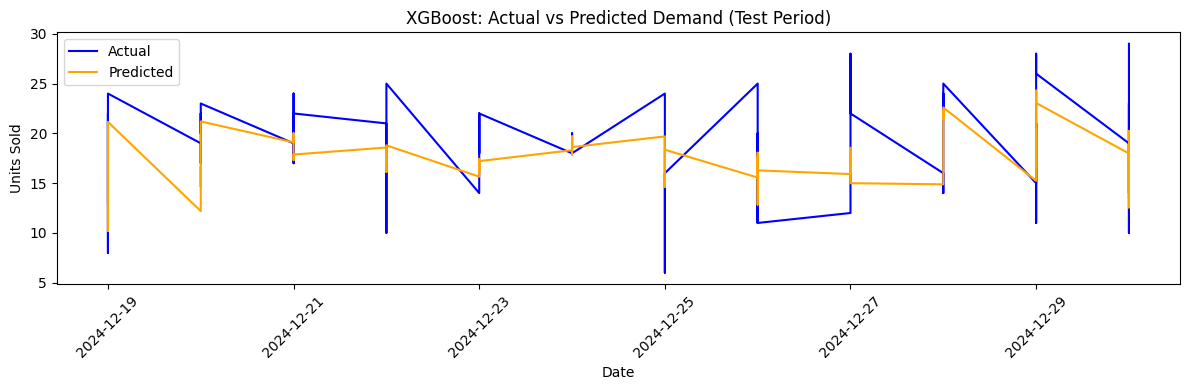

In [70]:
plt.figure(figsize=(12,4))
plt.plot(dates_test, y_test.values, label="Actual", color="blue")
plt.plot(dates_test, pred, label="Predicted", color="orange")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.title("XGBoost: Actual vs Predicted Demand (Test Period)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


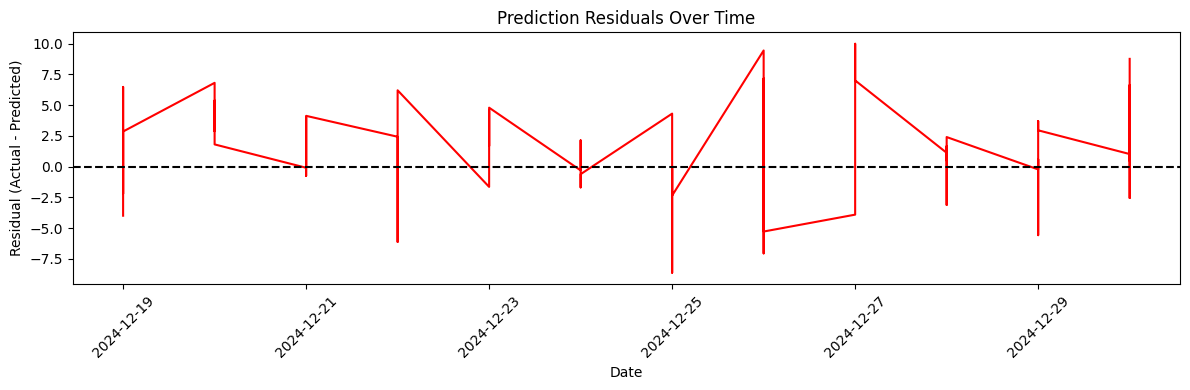

In [71]:
residuals = y_test.values - pred

plt.figure(figsize=(12,4))
plt.plot(dates_test, residuals, color="red")
plt.axhline(0, linestyle="--", color="black")
plt.xlabel("Date")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Prediction Residuals Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


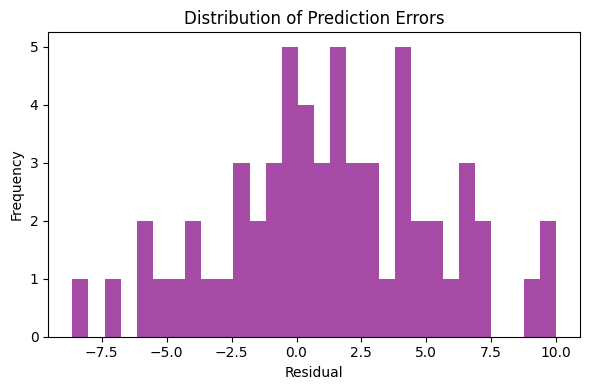

In [72]:
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, color="purple", alpha=0.7)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.tight_layout()
plt.show()


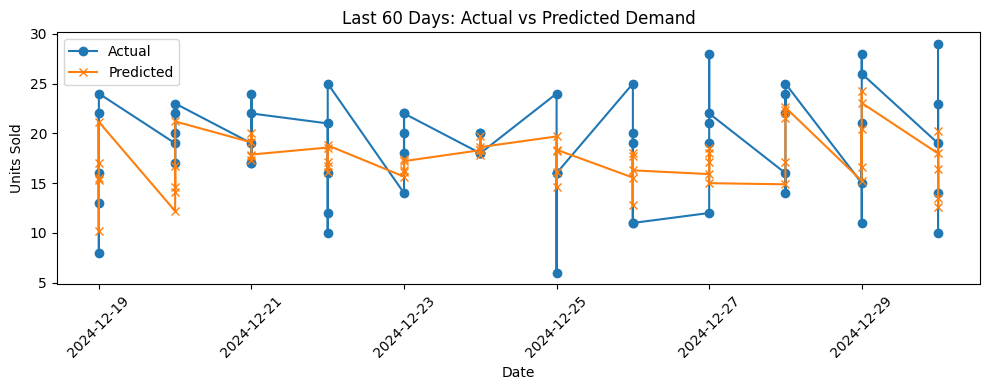

In [73]:
plt.figure(figsize=(10,4))
plt.plot(dates_test[-60:], y_test.values[-60:], label="Actual", marker="o")
plt.plot(dates_test[-60:], pred[-60:], label="Predicted", marker="x")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.title("Last 60 Days: Actual vs Predicted Demand")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


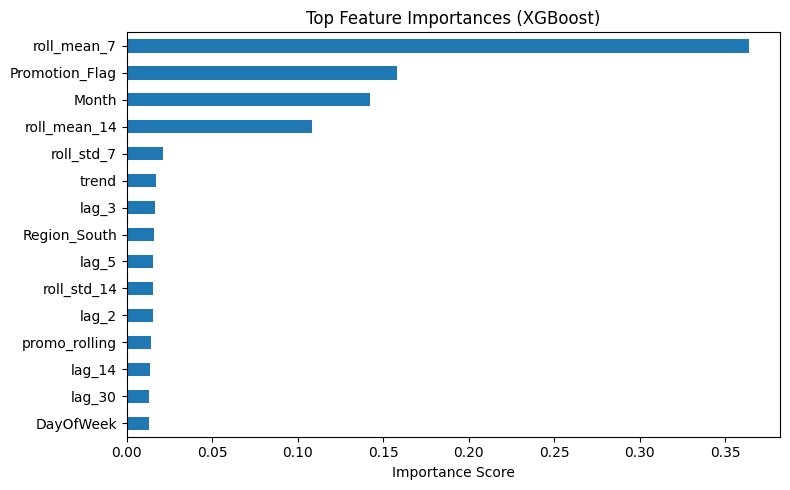

In [74]:


importance = pd.Series(
    model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(8,5))
importance.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [75]:
model.save_model("xgboost_demand_model.json")
print("Saved: xgboost_demand_model.json")


Saved: xgboost_demand_model.json


In [76]:
residuals_df = pd.DataFrame({
    "Residual": residuals
})

residuals_df.to_csv("demand_residuals_xgboost_morefeatures.csv", index=False)
print("Saved: demand_residuals_xgboost_morefeatures.csv")


Saved: demand_residuals_xgboost_morefeatures.csv


In [77]:
last_features = X.iloc[-1:].copy()
last_features.to_csv("last_known_features_xgboost_morefeatures.csv", index=False)

print("Saved: last_known_features_xgboost_morefeatures.csv")


Saved: last_known_features_xgboost_morefeatures.csv


In [78]:
pd.Series(X.columns).to_csv(
    "feature_columns_xgboost_morefeatures.csv",
    index=False,
    header=["feature_name"]
)




finding best xgboost for good r2

In [79]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    "n_estimators": [200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700],
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.01,0.02, 0.03, 0.05, 0.1],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.6, 0.7,0.8, 0.9]
}

base_model = XGBRegressor(objective="reg:squarederror")

grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring="r2",      # IMPORTANT → optimize R²
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_

print("Best Params:", grid.best_params_)


Fitting 3 folds for each of 1760 candidates, totalling 5280 fits
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.7}


In [80]:
pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R2   : {r2:.3f}")


MAE  : 3.45
RMSE : 4.17
R2   : 0.334
